In [1]:
import numpy as np
import pandas as pd
!apt-get install python3-bs4
from bs4 import BeautifulSoup
!pip install lxml
from bs4 import BeautifulSoup
import requests
import urllib.parse
import json
import re
import folium
from google.colab import drive
import time
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import scipy
!pip install geopandas
import geopandas
import logging
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/48376580/google-colab-how-to-read-data-from-my-google-drive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive

#from google.colab import auth
#from oauth2client.client import GoogleCredentials

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python3-chardet python3-html5lib python3-lxml python3-pkg-resources
  python3-six python3-webencodings
Suggested packages:
  python3-genshi python3-lxml-dbg python-lxml-doc python3-setuptools
The following NEW packages will be installed:
  python3-bs4 python3-chardet python3-html5lib python3-lxml
  python3-pkg-resources python3-six python3-webencodings
0 upgraded, 7 newly installed, 0 to remove and 7 not upgraded.
Need to get 1,442 kB of archives.
After this operation, 6,141 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-bs4 all 4.6.0-1 [67.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg-resources all 39.0.1-2 [98.8 kB]

In [0]:
ENABLE_DEBUG = False
DISPLAY_FULL_DATAFRAME = True

# Default instructions to read from/write to files
readfromfile_google_maps_api_results = False
readfromfile_foursquare_api_results = False
readfromfile_final_data = True
writetofile_google_maps_api_results = True
writetofile_foursquare_api_results = True
writetofile_final_data = True

# Override as preferred
readfromfile_google_maps_api_results = True
readfromfile_foursquare_api_results = True
readfromfile_final_data = True
writetofile_google_maps_api_results = False
writetofile_foursquare_api_results = False
writetofile_final_data = True

VERSION = '20200101'
LIMIT = 100
RADIUS = 700

# When determining the optimum number of clusters, scope between MIN_NUM_CLUSTERS and MAX_NUM_CLUSTERS inclusive
MAX_NUM_CLUSTERS = 14

DENVER_NEIGHBORHOODS_GEOJSON_URL = 'https://raw.githubusercontent.com/dntrply/coursera_capstone/master/data/denver_neighborhoods.geojson'


In [0]:
maps_key='redacted'
CLIENT_ID = 'redacted'
CLIENT_SECRET = 'redacted'
zillow_id = 'redacted'

In [0]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
if (ENABLE_DEBUG):
  logger.setLevel(logging.DEBUG)

if (DISPLAY_FULL_DATAFRAME):
  pd.options.display.max_rows = None
  pd.options.display.max_columns = None

In [4]:
mount_google_drive = (readfromfile_google_maps_api_results | readfromfile_foursquare_api_results | writetofile_google_maps_api_results | writetofile_foursquare_api_results | writetofile_final_data)

# Mount the Google drive - This is used to cache and hold results so the APIs do not have to be repeatedly invoked
# Note that is interactive and requires the user to select an account, agree to the access, and input the key
if (mount_google_drive):
  drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def scrape_wikipedia():
  """ Scrape the https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Denver#Central wikipedia page to retrieve the names of the neighborhoods
  Parameters: none
  Returns: A DataFrame of the neighborhood names
  """
  neighborhoods_list = []
  neighborhood_url = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Denver#Central'
  source = requests.get(neighborhood_url).text
  soup = BeautifulSoup(source, 'lxml')
  unordered_categories = soup.ul
  # Let's focus on entries such as the below fom the scraped page:

	# <a href="/wiki/Baker,_Denver" title="Baker, Denver">Baker</a>
	# <a class="mw-redirect" href="/wiki/Capitol_Hill,_Denver" title="Capitol Hill, Denver">Capitol Hill</a>
	# <a class="new" href="/w/index.php?title=Central_Business_District,_Denver&amp;action=edit&amp;redlink=1" title="Central Business District, Denver (page does not exist)">Central Business District</a>

  # Upon observing the data, the following is concluded:
  # Get all the tags with the href attribute that matches the string ',_Denver'
  # Note that the Denver International Airport entry does not match this pattern; to include that neighborhood, we include the string 'Denver_International' as well
  # We also get the title attribute that has the comma separated neighborhood and city name
  # Sloan's Lake is an exception as it does not have the ',_Denver' in the href attribute. It has '_Lake' so we include it below
  nhoods3_df = pd.DataFrame([a_tag['title']] for a_tag in soup.find_all(href=re.compile(',_Denver|Denver_International|_Lake')))
  logging.debug(f'nhoods3_df = {nhoods3_df}')

  # We need to further clean up the data. Notice that towards the end, in addition to the 78 'official' neighborhoods, there are a few more non-official neighborhoods. We will not be including those in this project.
  # A few neighborhoods have the name of the State following the city - let's remove the name of the state.
  # The source page also has flagged certain neighborhood entries with the text '(page does not exist)'. We would be stripping that off as well.
  # It turns out 'Park Hill' is not a neighborhood - so we shall exclude it from here
  nhoods3_df = nhoods3_df[nhoods3_df[0] != 'Park Hill, Denver']

  nhoods3_df = nhoods3_df.iloc[:78]

  nhoods4_df = pd.DataFrame(nhoods3_df[0].str.replace('(, Denver)?(, Colorado)?( \(page does not exist\))?', ''))
  logging.debug(f'nhoods4_df = {nhoods4_df}')
  nhoods5_df = pd.DataFrame(nhoods4_df[0].astype(str) +  ', Denver')
  logging.debug(f'nhoods5_df = {nhoods5_df}')

  return (nhoods5_df)



In [0]:
# url encode given string
def url_encode(in_str):
  in_str.replace(', ', '+')
  return urllib.parse.quote(in_str)

In [0]:
def invoke_map_api(nhoods_list):
  """ Invoke the Google maps API against a list of neighborhoods and retrieve their coordinates
  Parameters: nhoods_list - A list of neighborhoods
  Returns: A list of latitudes of the successful neighborhoods
           A list of longitudes of the successful neighborhoods
           A list of the names of the successful neighborhoods
           A list of the index of the successful neighborhoods
           A list of the names of the failed neighborhoods
           A list of the index of the ailed neighborhoods
  """
  # go through and make the Google maps api call and retrieve the lat/long for each nhood.
  # it is possible that some of these neighborhoods are not supported by the Google Maps API
  # We will choose to exclude such neighborhoods from the final analysis
  maps_url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}+US&key={}'
  nhoods_failed = []
  nhoods_succeeded = []
  nhoods_lat = []
  nhoods_lng = []
  nhoods_succeeded_index = []
  nhoods_failed_index = []

  for idx, nhood in enumerate(nhoods_list):
    # print(maps_url.format(nhood, maps_key))
    response = requests.get(maps_url.format(nhood, maps_key))
    # print(response.status_code)
    # print(response.text)
    # print(response.json())
    if (response.status_code != 200):
      print(nhood)
      nhoods_failed.append(nhood)
      nhoods_failed_inex.append(nhood)
    else:
      # Google maps returned success - 
      # extract the latitude/longitude
      response_json = json.loads(response.text)
      lat = response_json['results'][0]['geometry']['location']['lat']
      lng = response_json['results'][0]['geometry']['location']['lng']
      nhoods_succeeded.append(nhood)
      nhoods_lat.append(lat)
      nhoods_lng.append(lng)
      nhoods_succeeded_index.append(idx)

  logging.debug(f'nhoods_succeeded = {nhoods_succeeded}')
  logging.debug(f'nhoods_lat = {nhoods_lat}')
  logging.debug(f'nhoods_lng = {nhoods_lng}')
  logging.debug(f'nhoods_failed = {nhoods_failed}')
  logging.debug('Succeeded: {}'.format(len(nhoods_succeeded)))
  logging.debug('Failed: {}'.format(len(nhoods_failed)))

  return(nhoods_lat, nhoods_lng, nhoods_succeeded, nhoods_succeeded_index, nhoods_failed, nhoods_failed_index)


In [0]:
def get_coordinates(neighborhood_names):
  """ Use the Google Maps API and determine the latitude and longitude
  Parameters: A DataFrame with the neighborhood names
  Returns: A DataFrame with the neighborhood names, the latitude and the longitude
  """
  # Typical Google Maps API calls show a '+' and not a ', ' between the address parts
  # Replace
  nhoods5_df = pd.DataFrame(neighborhood_names[0].str.replace(', ', '+'))
  logging.debug(f'nhoods5_df = {nhoods5_df}')

  # URL encode the neighborhood names in preparation of the calls to the Google Maps API
  #nhoods6_df = nhoods5_df.applymap(url_encode)
  nhoods6_df = nhoods5_df.applymap(url_encode)
  logging.debug(f'nhoods6_df = {nhoods6_df}')

  # Make a list of the neighborhood names
  nhoods_list = nhoods6_df[0].to_list()
  logging.debug(f'nhoods_list = {nhoods_list}')

  nhoods_lat, nhoods_lng, _, _, _, _ = invoke_map_api(nhoods_list)

  nhoods9_df = pd.DataFrame({'Neighborhood': neighborhood_names[0], 'Latitude': nhoods_lat, 'Longitude': nhoods_lng})
  logging.debug(nhoods9_df)

  return(nhoods9_df)

In [0]:
def get_neighborhood_coordinates():
  """ Prepares a DataFrame that returns the neighborhoods and their coordinates. Note that
  * the Wikipedia pages are scraped for the neighborhoods
  * the neighborhood names are pre-processed as desired
  * The Google Maps API is invoked against the neighborhoods to  determine the coordinates
  Parameters: none
  Returns:
  A DataFrame comprising the neighborhoods and the latitude and longitude of each neighborhood
  """
  neighborhood_names =  scrape_wikipedia()
  return (get_coordinates(neighborhood_names))


In [0]:
# Prepare the DataFrame with the latitude and longitude information from the Google Maps API
# Read data from file if so desired
if (readfromfile_google_maps_api_results):
  nhoods10_df = pd.read_csv('/content/drive/My Drive/denver_neighborhoods_coordinates.csv')
else:
  nhoods10_df = get_neighborhood_coordinates()
  if (writetofile_google_maps_api_results):
    nhoods10_df.to_csv('/content/drive/My Drive/denver_neighborhoods_coordinates.csv', sep=',', index=False)

# Display the neighborhood information so that we have a visual context
logging.debug(f'nhoods10_df = {nhoods10_df}')
logging.debug(f'len of nhoods10_df = {len(nhoods10_df)}')

Let's plot the neighborhoods on a Folium map to get a visual context of the neighborhoods

In [11]:
# let's plot a folium map with all the 78 maps displayed on it
# Center the map around a mean latitude and longitude
mean_lat = nhoods10_df['Latitude'].mean()
mean_lng = nhoods10_df['Longitude'].mean()

denver_map = folium.Map(width='80%', height='80%', location=[mean_lat, mean_lng], zoom_start=11)

for nhood, lat, lng in zip(nhoods10_df['Neighborhood'], nhoods10_df['Latitude'], nhoods10_df['Longitude']):
  popup_label = folium.Popup(nhood, parse_html=True)
  folium.CircleMarker(location=[lat, lng],
                      radius=5,
                      popup=popup_label,
                      color='blue',
                      fill='True',
                      fillColor='#3186cc',
                      fill_opacity=0.7,
                      parse_html=False).add_to(denver_map)
denver_map

The next phase of the project is where we use the FourSquare APIs to get the favorite venues in the neighborhoods. From here we shall cluster these neighborhoods

In [0]:
def getNearbyVenues(names, latitudes, longitudes, radius = 700):
  """getNearbyVenues returns a DataFrame that comprises of all the neighbourhoods to be clustered together
  with the venues of interest around each neighbourhood
  Parameters:
  names : typically pandas Series of names
  latitudes: typically pandas Serie of latitudes
  longitudes: typically pandas Series of longitudes

  Returns:
  A DataFrame comprising of the venues of interest together withthe cluster elemnt they originally reference
  """
  venues_list = []
  # Loop through each of the entries in the input above
  for name, lat, lng in zip(names, latitudes, longitudes):
    
    # For each of these entries, let's now et the venues of interest
    four_square_url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
                                                                        CLIENT_ID,
                                                                        CLIENT_SECRET,
                                                                        VERSION,
                                                                        lat, lng,
                                                                        radius,
                                                                        LIMIT)
    results = requests.get(four_square_url).json()['response']['groups'][0]['items']


    interest = [(name, lat, lng, venue_row['venue']['name'], venue_row['venue']['location']['lat'], venue_row['venue']['location']['lng'], venue_row['venue']['categories'][0]['name'])  for venue_row in results]
    venues_list.append(interest)
    # Give some time between calls to FourSquare API
    time.sleep(.5)

  
  # Now that we have the array of interesting venues for each cluster element,
  # build a DataFrame from the same


  nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])

  return nearby_venues

In [0]:
# For each neghborhood now, we will get the venues of interest by calling the
# FourSquare APIs
if (readfromfile_foursquare_api_results):
  # read from file
  denver_venues = pd.read_csv('/content/drive/My Drive/denver_four_square_data.csv')
else:
  denver_venues = getNearbyVenues(nhoods10_df['Neighborhood'], nhoods10_df['Latitude'], nhoods10_df['Longitude'], radius=RADIUS)
  # Name the columns
  denver_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Name', 'Venue Latitude', 'Venue Longitude', 'Venue Category']

  # See if we need to write back to file for later use
  if (writetofile_foursquare_api_results):
    denver_venues.to_csv('/content/drive/My Drive/denver_four_square_data.csv', sep=',', index=False)
    logging.debug('denver_venues content written to file')

logging.debug(f'denver_venues = {denver_venues.head()}')

In [14]:
# Determine the total number of venues returned
denver_venues.shape

(2205, 7)

In [0]:
# Do a one hot encoding of the Venue Category
denver_onehot = pd.get_dummies(denver_venues[['Venue Category']], prefix='', prefix_sep='')
# Note that Neighborhood happens to be one of the category types!! We will therefore add the Neighborhood column back in but name the column something other than 'Neighborhood'
# Add the neighborhood column back in so that we may do a groupby
denver_onehot['Denver_Neighborhood'] = denver_venues['Neighborhood']
# Move the newly added neighborhood column to the start
column_list = [denver_onehot.columns[-1]] + list(denver_onehot.columns[:-1])
denver_onehot = denver_onehot[column_list]
#logging.debug(f'denver_onehot = {denver_onehot}')

In [0]:
# Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
denver_grouped = denver_onehot.groupby(by='Denver_Neighborhood').mean().reset_index()
# We do not need the neighborhood column any more - drop it
denver_grouped_cluster = denver_grouped.drop('Denver_Neighborhood', axis=1)
logging.debug(f'denver_grouped_cluster = {denver_grouped_cluster.head(2)}')

As a measure of the popular venues at a location, let's review the venue information that was retrieved

In [17]:
# Display the number of venues per neighborhood
denver_venues.groupby('Neighborhood').count()

# Note below that the counts reveal some neighborhoods have as many as a 100 venue categories; some as few as 1.

,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Athmar Park, Denver",4,4,4,4,4,4
"Auraria, Denver",39,39,39,39,39,39
"Baker, Denver",30,30,30,30,30,30
"Barnum West, Denver",6,6,6,6,6,6
"Barnum, Denver",8,8,8,8,8,8
"Bear Valley, Denver",4,4,4,4,4,4
"Belcaro, Denver",1,1,1,1,1,1
"Berkeley, Denver",60,60,60,60,60,60
"Capitol Hill, Denver",89,89,89,89,89,89


#### Let's find out how many unique venue categories exist

In [18]:
len(denver_venues['Venue Category'].unique())

299

Let's print each neighborhood, along with the top 5 most common venues

In [19]:
num_top_venues = 5

for hood in denver_grouped['Denver_Neighborhood']:
  logging.info(f'---- + {hood} + ----')
  temp = denver_grouped[denver_grouped['Denver_Neighborhood'] == hood].T.reset_index()
  temp = temp.iloc[1:]
  temp.columns = ['venue', 'freq']
  temp['freq'] = temp['freq'].astype(float)
  temp = temp[temp['freq'] != 0.0]
  temp = temp.round({'freq' : 2})
  logging.info(f"{temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues)}")

INFO:root:---- + Athmar Park, Denver + ----
INFO:root:                   venue  freq
0           Home Service  0.25
1                   Park  0.25
2  Vietnamese Restaurant  0.25
3        Warehouse Store  0.25
INFO:root:---- + Auraria, Denver + ----
INFO:root:                          venue  freq
0  Theme Park Ride / Attraction  0.10
1                    Theme Park  0.10
2            Light Rail Station  0.08
3           American Restaurant  0.08
4                   Coffee Shop  0.05
INFO:root:---- + Baker, Denver + ----
INFO:root:                  venue  freq
0           Coffee Shop  0.10
1          Intersection  0.07
2    Chinese Restaurant  0.07
3  Marijuana Dispensary  0.07
4   Arts & Crafts Store  0.03
INFO:root:---- + Barnum West, Denver + ----
INFO:root:                 venue  freq
0  American Restaurant  0.17
1    Convenience Store  0.17
2       Discount Store  0.17
3           Donut Shop  0.17
4         Home Service  0.17
INFO:root:---- + Barnum, Denver + ----
INFO:root:        

In [0]:
def most_common_venues(row, num_top_venues):
  """ Get the most common venues
  Parameters: row - A DataSeries of the  mean of the frequency of occurrence of each category with the neighborhood name an index
              num_top_venues - an integer indicating the number of top venue categories
  Returns: An array of the top 5 venue categories. Where the top venue categories are less than 5, the top categories are returned
           and the remainder category types are set as '---'
  """
  row_categories = row.iloc[1:]
  row_categories_sorted = row_categories.sort_values(ascending=False)
  
  # Provide an appropriate name to the axis
  row_categories_sorted.rename_axis('Venue Type', inplace = True)
  
  # Convert to a DataFrame with the series index being a column
  row_categories_sorted = row_categories_sorted.reset_index(name='freq')
  
  # Replace all venue cetegory types that are not found at the neighborhood (freq = 0) to '---'
  row_categories_sorted.loc[(row_categories_sorted['freq'] == 0), 'Venue Type'] = '---'
  
  return row_categories_sorted['Venue Type'].head(num_top_venues).values

In [21]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Denver_Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Denver_Neighborhood'] = denver_grouped['Denver_Neighborhood']

for ind in np.arange(denver_grouped.shape[0]):
  neighborhoods_venues_sorted.iloc[ind, 1:] = most_common_venues(denver_grouped.iloc[ind, :], num_top_venues)

# logging.debug(f'neighborhoods_venues_sorted = {neighborhoods_venues_sorted}')
neighborhoods_venues_sorted

,Denver_Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Athmar Park, Denver",Park,Vietnamese Restaurant,Home Service,Warehouse Store,---
1,"Auraria, Denver",Theme Park,Theme Park Ride / Attraction,Light Rail Station,American Restaurant,Fast Food Restaurant
2,"Baker, Denver",Coffee Shop,Marijuana Dispensary,Chinese Restaurant,Intersection,Residential Building (Apartment / Condo)
3,"Barnum West, Denver",Mexican Restaurant,Convenience Store,Discount Store,Home Service,American Restaurant
4,"Barnum, Denver",Mexican Restaurant,Hookah Bar,Marijuana Dispensary,Market,Burger Joint
5,"Bear Valley, Denver",Park,Gym / Fitness Center,Pool,---,---
6,"Belcaro, Denver",Park,---,---,---,---
7,"Berkeley, Denver",Brewery,Coffee Shop,Pizza Place,Breakfast Spot,Bar
8,"Capitol Hill, Denver",Pizza Place,Coffee Shop,Sandwich Place,Nightclub,Pub
9,"Central Business District, Denver",Hotel,American Restaurant,Theater,Italian Restaurant,Coffee Shop


We next need to cluster the neighborhoods
We iterate through the clusters
We will review where the elbow drops - but we will also review the "spread" of the neighborhoods among the clusters.  We will favor the neighborhoods with a "spread"

In [0]:
kmeans_errors_arr = []
kmeans_labels_arr = []
kmeans_freqs_arr = []
for nclusters in range(1, MAX_NUM_CLUSTERS+1):
  kmeans_classifier = KMeans(nclusters, random_state=0).fit(denver_grouped_cluster)

  # Compute the error
  kmeans_error = kmeans_classifier.inertia_
  kmeans_labels = kmeans_classifier.labels_
  _ ,kmeans_freqs = np.unique(kmeans_labels, return_counts=True)

  kmeans_errors_arr.append(kmeans_error)
  kmeans_labels_arr.append(kmeans_labels)
  kmeans_freqs_arr.append(kmeans_freqs)

logging.debug(f'kmeans_errors_arr = {kmeans_errors_arr}')
logging.debug(f'kmeans_labels_arr = {kmeans_labels_arr}')
logging.debug(f'kmeans_freqs_arr = {kmeans_freqs_arr}')




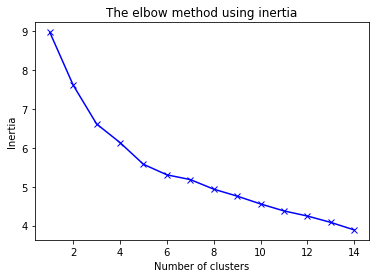

In [23]:
# Plot the inertia (SSE) to determine the elbow

plt.plot(range(1, MAX_NUM_CLUSTERS+1), kmeans_errors_arr, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('The elbow method using inertia')
plt.show()

In [0]:
# We will pick the number of clusters to be 6 (index 5)
kclusters = 6
cluster_labels = kmeans_labels_arr[kclusters - 1]

In [0]:
# Build out the final elements of the data

denver_final = nhoods10_df.sort_values(by='Neighborhood').reset_index(drop=True)
denver_final.insert(0, 'Cluster Label', cluster_labels)

In [26]:
# Determine the number of neighborhoods in each cluster
denver_final.groupby('Cluster Label').count()

,Neighborhood,Latitude,Longitude
Cluster Label,,,
0,7,7,7
1,64,64,64
2,2,2,2
3,1,1,1
4,2,2,2
5,2,2,2


In [0]:
# Let's draw the clusters on the Denver map
denver_cluster_map = folium.Map(width='80%', height='80%', location=[mean_lat, mean_lng], zoom_start=11)
# Let's get the range of colors
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(color) for color in colors_array]
# add markers to the cluster map and display the cluster map
for nhood, lat, lng, cluster in zip(denver_final['Neighborhood'],
                                    denver_final['Latitude'],
                                    denver_final['Longitude'],
                                    denver_final['Cluster Label']):
  label = folium.Popup(nhood + ', Cluster ' + str(cluster), parse_html=True)
  folium.CircleMarker(location=[lat, lng],
                      radius=7,
                      popup=label,
                      color=rainbow[cluster],
                      fill=True,
                      fill_color=rainbow[cluster],
                      fill_opacity=0.9).add_to(denver_cluster_map)



In [28]:
denver_cluster_map

In [0]:
def get_house_values(denver_final):
  """ Get the median house values for each neighborhood
  Parameters: denver_final - a DataFrame that contains neighborhoods
  Return: A DataFrame that adds the median house values and the denver_final DataFrame
  """
  # As a first step, let's use the Zillow APIs and get the house prices for each of the 76 neighborhoods above
  # We will then try to determine the neighborhood with the lowest, highest and median price
  # Start with each of the neighborhoods
  house_values = []
  url_zillow = 'http://www.zillow.com/webservice/GetDemographics.htm?zws-id={}&city=Denver&state=Colorado&neighborhood={}'

  for nhood in denver_final['Neighborhood'].str.replace(', Denver', ''):
    response = requests.get(url_zillow.format(zillow_id, url_encode(nhood)))
    house_value=np.NAN
    if (response.status_code == 200):
      soup = BeautifulSoup(response.text, 'lxml')
      if (soup.message.code.text == '0'):
        # Retrieve the values - converting the same to int
        house_value = int(soup.pages.value.text)
        house_values.append(house_value)
    time.sleep(.5)

  logging.debug(f'house_values = {house_values}')
  logging.debug(f'number of results = {len(house_values)}')

  denver_prices = denver_final
  denver_prices['House Price'] = house_values
  return denver_prices


In [0]:
if (readfromfile_final_data):
  denver_prices = pd.read_csv('/content/drive/My Drive/final_denver_neighborhood_prices.csv')
else:
  denver_prices = get_house_values(denver_final)
  if (writetofile_final_data):
    denver_prices.to_csv('/content/drive/My Drive/final_denver_neighborhood_prices.csv', sep=',', index=False)
    logging.debug('Denver final data content written to file')

logging.debug(f'denver_prices = {denver_prices.head()}')

In [0]:
# Build out the DataFrame to include the neighborhoods, the top 5 venue categories, the cluster label and the median housing price
neighborhood_venues_details = neighborhoods_venues_sorted
neighborhood_venues_details[['Cluster Label', 'House Price']] = denver_prices[['Cluster Label', 'House Price']]

In [32]:
neighborhood_venues_details.groupby(['Cluster Label', 'Denver_Neighborhood']).first()

1st Most Common Venue  \
Cluster Label Denver_Neighborhood                                            
0             Athmar Park, Denver                                     Park   
              Bear Valley, Denver                                     Park   
              Fort Logan, Denver                                      Park   
              Harvey Park, Denver                            Historic Site   
              Ruby Hill, Denver                                Flower Shop   
              Stapleton, Denver                                       Park   
              Villa Park, Denver                                      Park   
1             Auraria, Denver                                   Theme Park   
              Baker, Denver                                    Coffee Shop   
              Barnum West, Denver                       Mexican Restaurant   
              Barnum, Denver                            Mexican Restaurant   
              Berkeley, Denver                                     Brewery   
              Capitol Hill, Denver                             Pizza Place   
              Central Business District, Denver                      Hotel   
              Chaffee Park, Denver                           Grocery Store   
              Cheesman Park, Denver                       Botanical Garden   
              Cherry Creek, Denver                          Clothing Store   
              City Park West, Denver                           Pizza Place   
              City Park, Denver                                Zoo Exhibit   
              Civic Center, Denver                             Coffee Shop   
              Clayton, Denver                                  Coffee Shop   
              Cole, Denver                            Marijuana Dispensary   
              College View / South Platte, Denver               Strip Club   
              Congress Park, Denver                            Coffee Shop   
              Cory-Merrill, Denver                             Coffee Shop   
              Country Club, Denver                                     ATM   
              Denver International Airport, Denver             Coffee Shop   
              East Colfax, Denver                       Mexican Restaurant   
              Elyria-Swansea, Denver                                  Food   
              Five Points, Denver                                  Brewery   
              Gateway / Green Valley Ranch, Denver    Fast Food Restaurant   
              Globeville, Denver                              Intersection   
              Goldsmith, Denver                             Sandwich Place   
              Hale, Denver                                  Sandwich Place   
              Hampden South, Denver                      Mobile Phone Shop   
              Hampden, Denver                                  Pizza Place   
              Highland, Denver                                 Pizza Place   
              Hilltop, Denver                               Ice Cream Shop   
              Jefferson Park, Denver                    Mexican Restaurant   
              Kennedy, Denver                                  Pizza Place   
              Lincoln Park, Denver                             Coffee Shop   
              Lowry, Denver                                           Park   
              Mar Lee, Denver                                Grocery Store   
              Marston, Denver                               Cosmetics Shop   
              Montbello, Denver                       Fast Food Restaurant   
              Montclair, Denver                                       Park   
              North Capitol Hill, Denver                       Coffee Shop   
              North Park Hill, Denver                               Bistro   
              Northeast Park Hill, Denver           Furniture / Home Store   
              Overland, Denver                                  Hobby Shop 

The next step is to read the [geojson coordinates](https://raw.githubusercontent.com/dntrply/coursera_capstone/master/data/denver_neighborhoods.geojson) of the 78 neighborhoods.
The GeoJson data for the choropleth map was derived from the shapefile obtained at [Statistical Neighborhoods](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-statistical-neighborhoods). The shapefile in loaded in the program and QGIS and the GeoJson data then exported.


In [0]:
neighborhood_geo = geopandas.read_file(DENVER_NEIGHBORHOODS_GEOJSON_URL)
logging.debug(f'neighborhood_geo = {neighborhood_geo}')

The neighborhood information between the geojson file data and the data from Wikipedia have slight inconsistencies. These inconsistencies - upon review of the data - is as follows:

geojson data | data from scraping Wikipedia
--- | ---
just the neighborhood name | the neighborhood name, followed by ', Denver'
CBD | Central Business District
College View - South Platte | College View / South Platte
Cory - Merrill | Cory-Merrill
DIA | Denver International Airport
Elyria Swansea | Elyria-Swansea
Gateway - Green Valley Ranch | Gateway / Green Valley Ranch
Lowry Field | Lowry
Sloan Lake | Sloan's Lake


In [0]:
# Clean up the above listed inconsistencies
data_df = denver_prices
data_df['Neighborhood'] = data_df.Neighborhood.str.replace(', Denver', '')
data_df['Neighborhood'] = data_df.Neighborhood.str.replace('Central Business District', 'CBD')
data_df['Neighborhood'] = data_df.Neighborhood.str.replace('College View / South Platte', 'College View - South Platte')
data_df['Neighborhood'] = data_df.Neighborhood.str.replace('Cory-Merrill', 'Cory - Merrill')
data_df['Neighborhood'] = data_df.Neighborhood.str.replace('Denver International Airport', 'DIA')
data_df['Neighborhood'] = data_df.Neighborhood.str.replace('Elyria-Swansea', 'Elyria Swansea')
data_df['Neighborhood'] = data_df.Neighborhood.str.replace('Gateway / Green Valley Ranch', 'Gateway - Green Valley Ranch')
data_df['Neighborhood'] = data_df.Neighborhood.str.replace('Lowry', 'Lowry Field')
data_df['Neighborhood'] = data_df.Neighborhood.str.replace("Sloan's", 'Sloan')

logging.debug(f'data_df = {data_df}')

In [35]:
# Build out the final choropleth map
mean_lat = data_df['Latitude'].mean()
mean_lng = data_df['Longitude'].mean()

denver_choropleth_map = folium.Map(location=[mean_lat, mean_lng], width='80%', height='80%', zoom_start=11)
folium.Choropleth(geo_data=neighborhood_geo, 
                  name='choropleth', 
                  data=data_df, 
                  legend_name='Housing Prices', 
                  fill_color='YlOrRd', 
                  columns=['Neighborhood', 'House Price'], 
                  highlight = True,
                  key_on='feature.properties.NBHD_NAME').add_to(denver_choropleth_map)


# Let's get the range of colors
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(color) for color in colors_array]

# add markers to the cluster map and display the choropleth map
for nhood, lat, lng, cluster, house_price in zip(data_df['Neighborhood'],
                                    data_df['Latitude'],
                                    data_df['Longitude'],
                                    data_df['Cluster Label'],
                                    data_df['House Price']):
  label = folium.Popup(nhood + ', Cluster ' + str(cluster) + ', Median Housing Price = $' + str(house_price), parse_html=True)
  folium.CircleMarker(location=[lat, lng],
                      radius=5,
                      popup=label,
                      color=rainbow[cluster],
                      fill=True,
                      fill_color=rainbow[cluster],
                      fill_opacity=0.9).add_to(denver_choropleth_map)

# Display the map
denver_choropleth_map



/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


This concludes the Capstone Project (Week 2)